In [1]:
pip install dmba==0.0.18

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from dmba import regressionSummary

no display found. Using non-interactive Agg backend


# 데이터 로드 및 전처리

In [3]:
# 데이터 로드
df_t = pd.read_csv("/content/drive/MyDrive/2022_IPS/final_data/지역명_사망자수(train).csv")
df_t = df_t.drop(columns=['Unnamed: 0'])
df_t.head()

,지역명,병원수,격리병상수,남은 격리병상수,총인구,요양기관수,60세 이상 - 계,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상,확진자수,사망자수
0,강원도,18.0,539.0,75.0,1347375.0,34.0,369970,116558,81374,56864,53119,38211,23844,440985.0,746
1,경상남도,35.0,940.0,176.0,3295942.0,129.0,774696,253193,179622,128375,99667,70217,43622,1052389.0,1134
2,경상북도,29.0,1046.0,271.0,2583157.0,111.0,719154,213011,162533,119640,100383,75400,48187,731978.0,1203
3,광주광역시,19.0,240.0,55.0,1477573.0,60.0,290547,96662,65287,52134,38610,23826,14028,518968.0,520
4,대구광역시,18.0,876.0,249.0,2410700.0,75.0,559877,182705,133421,95965,73211,47435,27140,734292.0,1243


In [4]:
# 이상치 확인
data = df_t['사망자수'].copy()
Q3, Q1 = np.percentile(data, [75,25])
IQR = Q3 - Q1
data[(Q1-1.5 * IQR > data)|(Q3+1.5 * IQR < data)]

6    2002
7    4504
Name: 사망자수, dtype: int64

In [5]:
# 이상치 값 가장 높은 서울특별시 행 제거
df_t = df_t[df_t.지역명 != '서울특별시']

In [6]:
# column 이름 변경
columns = ['loc','cnt_hos','bed','remain_bed','pop','nurse','total60','60-64','65-69','70-74','75-79','80-84','85-','conf','death']
var_name = pd.DataFrame(df_t.columns, columns, columns=['meaning'])
var_name

,meaning
loc,지역명
cnt_hos,병원수
bed,격리병상수
remain_bed,남은 격리병상수
pop,총인구
nurse,요양기관수
total60,60세 이상 - 계
60-64,60~64세
65-69,65~69세
70-74,70~74세


In [7]:
df_t.columns = columns
df_t.head()

,loc,cnt_hos,bed,remain_bed,pop,nurse,total60,60-64,65-69,70-74,75-79,80-84,85-,conf,death
0,강원도,18.0,539.0,75.0,1347375.0,34.0,369970,116558,81374,56864,53119,38211,23844,440985.0,746
1,경상남도,35.0,940.0,176.0,3295942.0,129.0,774696,253193,179622,128375,99667,70217,43622,1052389.0,1134
2,경상북도,29.0,1046.0,271.0,2583157.0,111.0,719154,213011,162533,119640,100383,75400,48187,731978.0,1203
3,광주광역시,19.0,240.0,55.0,1477573.0,60.0,290547,96662,65287,52134,38610,23826,14028,518968.0,520
4,대구광역시,18.0,876.0,249.0,2410700.0,75.0,559877,182705,133421,95965,73211,47435,27140,734292.0,1243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


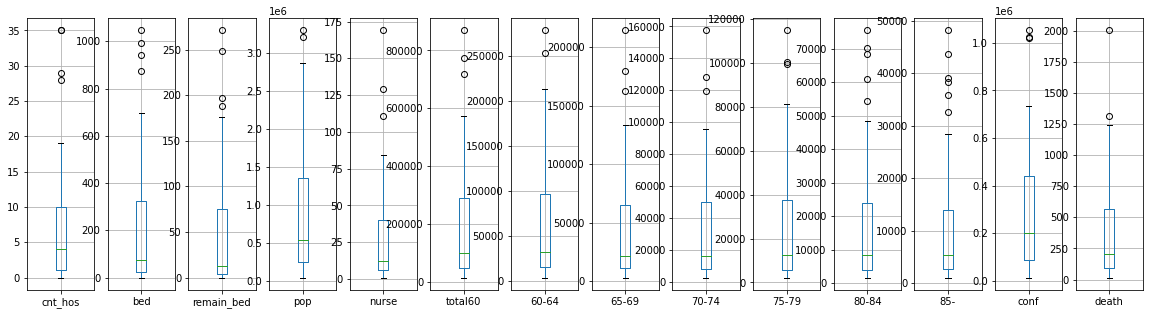

In [8]:
%matplotlib inline

# 이상치 제거 후 데이터 분포 확인
fig, axes = plt.subplots(nrows=1, ncols=14)
for (i,j) in zip(df_t.drop(columns=['loc']).columns, range(0,14)):
    df_t.boxplot(column=i, ax = axes[j])

plt.tight_layout()
fig.set_size_inches(20, 5)
plt.show()

In [9]:
# 결측치 확인
df_t.isnull().sum()

loc           0
cnt_hos       0
bed           0
remain_bed    0
pop           0
nurse         0
total60       0
60-64         0
65-69         0
70-74         0
75-79         0
80-84         0
85-           0
conf          0
death         0
dtype: int64

In [10]:
# 데이터 요약
df_t.describe()

,cnt_hos,bed,remain_bed,pop,nurse,total60,60-64,65-69,70-74,75-79,80-84,85-,conf,death
count,45.000000,45.000000,45.000000,4.500000e+01,45.0000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,4.500000e+01,45.000000
mean,7.555556,230.688889,50.577778,9.174405e+05,29.8000,204193.266667,66658.622222,46480.133333,34304.755556,26879.533333,18345.066667,11525.155556,3.072999e+05,402.733333
std,9.521639,304.297165,69.794663,8.804693e+05,37.3823,222864.132702,70036.494152,51507.646748,38441.473914,30298.378875,21125.448772,13184.530510,2.801179e+05,427.949997
min,0.000000,0.000000,0.000000,4.227800e+04,1.0000,14575.000000,4048.000000,2968.000000,2560.000000,2228.000000,1716.000000,1055.000000,1.373900e+04,16.000000
25%,1.000000,25.000000,4.000000,2.406450e+05,6.0000,48720.000000,16144.000000,11062.000000,7769.000000,5788.000000,3994.000000,2625.000000,8.813600e+04,95.000000
50%,4.000000,75.000000,13.000000,5.423360e+05,12.0000,97835.000000,32728.000000,21659.000000,16203.000000,12539.000000,8464.000000,5414.000000,1.991570e+05,208.000000
75%,10.000000,325.000000,75.000000,1.347375e+06,40.0000,290547.000000,96662.000000,65287.000000,50097.000000,37683.000000,23826.000000,14028.000000,4.409850e+05,563.000000
max,35.000000,1046.000000,271.000000,3.295942e+06,169.0000,869020.000000,278378.000000,214341.000000,157522.000000,114719.000000,75400.000000,48187.000000,1.052389e+06,2002.000000


# 상관계수 확인

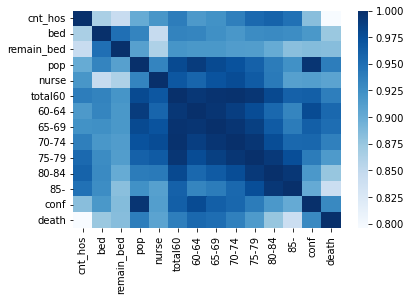

In [11]:
# 상관계수 확인
%matplotlib inline

cor = df_t.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Blues)
plt.show()

In [12]:
cor_target = abs(cor['death'])
print(cor_target)

cnt_hos       0.795857
bed           0.874048
remain_bed    0.884020
pop           0.939921
nurse         0.907597
total60       0.939254
60-64         0.955569
65-69         0.951409
70-74         0.937455
75-79         0.915948
80-84         0.876285
85-           0.841561
conf          0.929856
death         1.000000
Name: death, dtype: float64


In [13]:
# 상관계수 값이 0.9가 넘는 column만 선택
selected_cols = cor_target[cor_target > 0.9]
print("selected columns (correlation with target > 0.9)")
print(selected_cols)

df_t_sel = df_t[selected_cols.index]
df_t_sel.head()

selected columns (correlation with target > 0.9)
pop        0.939921
nurse      0.907597
total60    0.939254
60-64      0.955569
65-69      0.951409
70-74      0.937455
75-79      0.915948
conf       0.929856
death      1.000000
Name: death, dtype: float64


,pop,nurse,total60,60-64,65-69,70-74,75-79,conf,death
0,1347375.0,34.0,369970,116558,81374,56864,53119,440985.0,746
1,3295942.0,129.0,774696,253193,179622,128375,99667,1052389.0,1134
2,2583157.0,111.0,719154,213011,162533,119640,100383,731978.0,1203
3,1477573.0,60.0,290547,96662,65287,52134,38610,518968.0,520
4,2410700.0,75.0,559877,182705,133421,95965,73211,734292.0,1243


# train, validation, test set 생성

In [14]:
# data
X = df_t_sel.drop(columns=['death'])
# target
y = df_t_sel['death']

# train set : test set = 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
# train set : validation set = 8:2
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [15]:
print('train set', X_train.shape, y_train.shape)
print('validation set', X_valid.shape, y_valid.shape)
print('test set', X_test.shape, y_test.shape)

train set (28, 8) (28,)
validation set (8, 8) (8,)
test set (9, 8) (9,)


# Linear Regression

In [16]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)
y_pred = lnr.predict(X_test)

In [17]:
r2 = r2_score(y_test, y_pred)
print('r2 score of Linear Regression is ' + str(r2))

r2 score of Linear Regression is 0.7957484320845039


In [18]:
regressionSummary(y_test, lnr.predict(X_test))


Regression statistics

                      Mean Error (ME) : -86.7726
       Root Mean Squared Error (RMSE) : 158.4443
            Mean Absolute Error (MAE) : 115.6144
          Mean Percentage Error (MPE) : -18.1089
Mean Absolute Percentage Error (MAPE) : 35.1869


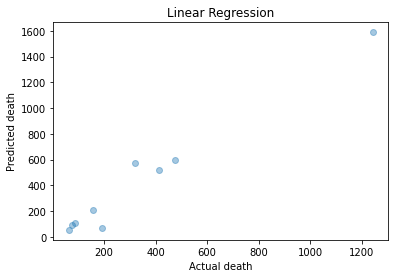

In [19]:
# 실제 사망자 수와 예측 사망자 수 비교
plt.scatter(y_test, y_pred, alpha=0.4)
plt.title("Linear Regression")
plt.xlabel("Actual death")
plt.ylabel("Predicted death")
plt.show()

# Lasso Regression

In [20]:
lar = Lasso(alpha=0.3)
lar.fit(X_train, y_train)
y_pred = lar.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+05, tolerance: 6.375e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [21]:
r2 = r2_score(y_test, y_pred)
print('r2 score of Lasso Regression is ' + str(r2))

r2 score of Lasso Regression is 0.8878181578823047


In [22]:
regressionSummary(y_test, lar.predict(X_test))


Regression statistics

                      Mean Error (ME) : -34.5491
       Root Mean Squared Error (RMSE) : 117.4236
            Mean Absolute Error (MAE) : 83.7542
          Mean Percentage Error (MPE) : -33.4394
Mean Absolute Percentage Error (MAPE) : 40.6320


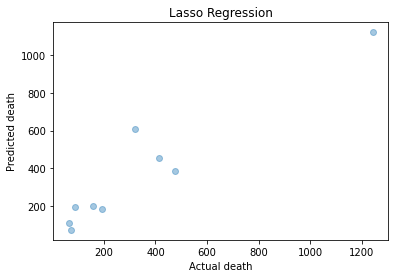

In [23]:
# 실제 사망자 수와 예측 사망자 수 비교
plt.scatter(y_test, y_pred, alpha=0.4)
plt.title("Lasso Regression")
plt.xlabel("Actual death")
plt.ylabel("Predicted death")
plt.show()

# Ridge Regression

In [24]:
rdr = Ridge(alpha=0.3)
rdr.fit(X_train, y_train)
y_pred = rdr.predict(X_test)

In [25]:
r2 = r2_score(y_test, y_pred)
print('r2 score of Ridge Regression is ' + str(r2))

r2 score of Ridge Regression is 0.7959516533119056


In [26]:
regressionSummary(y_test, rdr.predict(X_test))


Regression statistics

                      Mean Error (ME) : -86.7386
       Root Mean Squared Error (RMSE) : 158.3655
            Mean Absolute Error (MAE) : 115.5598
          Mean Percentage Error (MPE) : -18.1146
Mean Absolute Percentage Error (MAPE) : 35.1743


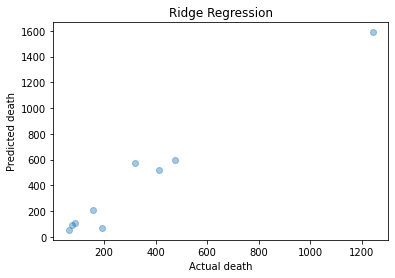

In [27]:
# 실제 사망자 수와 예측 사망자 수 비교
plt.scatter(y_test, y_pred, alpha=0.4)
plt.title("Ridge Regression")
plt.xlabel("Actual death")
plt.ylabel("Predicted death")
plt.show()

Lasso Regression이 성능이 가장 좋았고, Linear와 Ridge Regression는 성능이 유사했다.

# 실제 데이터에 적용

In [28]:
# 사망자 수를 예측할 시군구 데이터
df_p = pd.read_csv("/content/drive/MyDrive/2022_IPS/final_data/시도명_시군구명(predict).csv").drop(columns=['Unnamed: 0'])
df_p.head()

,시도명,시군구명,병원수,격리병상수,남은 격리병상수,총인구,요양기관수,60세 이상 - 계,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상,확진자수
0,강원도,강릉시,3.0,79.0,24.0,216542.0,3.0,61339,18656,13586,9988,8900,6185,4024,65832.0
1,강원도,동해시,2.0,66.0,1.0,87801.0,3.0,24762,7662,5655,4087,3680,2278,1400,28349.0
2,강원도,삼척시,1.0,51.0,8.0,65939.0,1.0,21481,6050,4525,3591,3311,2377,1627,17543.0
3,강원도,속초시,2.0,119.0,5.0,80054.0,2.0,22194,7239,4986,3556,3055,2062,1296,27323.0
4,강원도,영월군,1.0,27.0,1.0,36282.0,1.0,14753,4248,3297,2309,2283,1671,945,9242.0


In [29]:
# column 이름 변경
columns_p = ['loc_sido','loc_gun','cnt_hos','bed','remain_bed','pop','nurse','total60','60-64','65-69','70-74','75-79','80-84','85-','conf']
df_p.columns = columns_p
df_p.head()

,loc_sido,loc_gun,cnt_hos,bed,remain_bed,pop,nurse,total60,60-64,65-69,70-74,75-79,80-84,85-,conf
0,강원도,강릉시,3.0,79.0,24.0,216542.0,3.0,61339,18656,13586,9988,8900,6185,4024,65832.0
1,강원도,동해시,2.0,66.0,1.0,87801.0,3.0,24762,7662,5655,4087,3680,2278,1400,28349.0
2,강원도,삼척시,1.0,51.0,8.0,65939.0,1.0,21481,6050,4525,3591,3311,2377,1627,17543.0
3,강원도,속초시,2.0,119.0,5.0,80054.0,2.0,22194,7239,4986,3556,3055,2062,1296,27323.0
4,강원도,영월군,1.0,27.0,1.0,36282.0,1.0,14753,4248,3297,2309,2283,1671,945,9242.0


In [30]:
# 선택할 features
print(df_t_sel.columns)

Index(['pop', 'nurse', 'total60', '60-64', '65-69', '70-74', '75-79', 'conf',
       'death'],
      dtype='object')


In [31]:
predictors = df_p.drop(columns=['loc_sido', 'loc_gun', 'cnt_hos', 'bed', 'remain_bed', '80-84', '85-'])

In [32]:
# 사망자 수 예측
pred_death = []
for i in range(0, 206):
  pred_death.append(lar.predict(predictors.loc[[i]]))

In [33]:
df_pred_death = df_p.drop(columns=['cnt_hos', 'remain_bed', 'nurse'])
df_pred_death['pred_death'] = pd.DataFrame(pred_death)
df_pred_death

,loc_sido,loc_gun,bed,pop,total60,60-64,65-69,70-74,75-79,80-84,85-,conf,pred_death
0,강원도,강릉시,79.0,216542.0,61339,18656,13586,9988,8900,6185,4024,65832.0,146.119710
1,강원도,동해시,66.0,87801.0,24762,7662,5655,4087,3680,2278,1400,28349.0,78.083790
2,강원도,삼척시,51.0,65939.0,21481,6050,4525,3591,3311,2377,1627,17543.0,70.755636
3,강원도,속초시,119.0,80054.0,22194,7239,4986,3556,3055,2062,1296,27323.0,84.021723
4,강원도,영월군,27.0,36282.0,14753,4248,3297,2309,2283,1671,945,9242.0,63.371258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,충청북도,제천시,32.0,134768.0,39959,12590,9246,6191,5764,3910,2258,42422.0,103.891011
202,충청북도,증평군,0.0,37183.0,8734,2788,1954,1337,1225,887,543,15155.0,53.588268
203,충청북도,진천군,67.0,89514.0,18410,5699,4030,2787,2445,2112,1337,34557.0,69.397953
204,충청북도,청주시,445.0,855326.0,162294,56336,37220,25076,20488,14104,9070,297157.0,335.154591


In [34]:
df_pred_death.to_csv("라쏘회귀_예측결과.csv", mode='w', encoding='utf-8-sig')